## BP 2004 model 

Billette, F. J., & Brandsberg-Dahl, S. (2005, June). The 2004 BP velocity benchmark. In 67th EAGE Conference & Exhibition (pp. cp-1). European Association of Geoscientists & Engineers.

The raw data can be downloaded from [this website](https://wiki.seg.org/wiki/2004_BP_velocity_estimation_benchmark_model#Madagascar_processing_scripts%7C)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d
import scipy.signal
import scipy.io
import obspy
import os

In [2]:
in_dir = "./models_raw/"
out_dir = "./models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
def calc_dx_dt(f0, v):
    dx = v * 1/f0 / 7
    dy = dx
    dt = dx / v / 3
    return dx, dt

In [4]:
def ricker(f0, dt):
    nt = np.around(10/f0/dt)
    src = scipy.signal.ricker(nt, a=1/f0/dt)
    return src

In [5]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)

In [6]:
def load_BP_model():
    if not os.path.exists(os.path.join(in_dir, "vel_z6.25m_x12.5m_exact.segy.gz")):
        os.system("wget {} -P {}".format("http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_exact.segy.gz", in_dir))

    meta = obspy.read(os.path.join(in_dir, "vel_z6.25m_x12.5m_exact.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    
    nx, ny = vp.shape
    dx = 12.5 
    dy = 6.25
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy

    model = {"vp": vp/1e3, "x": x, "y":y, "dx":dx, "dy":dy, "nx":nx, "ny":ny}

    return model

BP_model = load_BP_model()

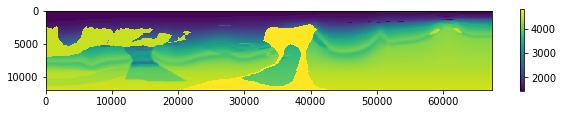

In [7]:
plt.figure(figsize=(10,5))
plt.pcolormesh(BP_model["x"][::10], BP_model["y"][::10], BP_model["vp"][::10,::10].T)
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.3)
plt.show()

In [8]:
def resample_model(x, y, model):
    
    ratio_x = (x[1] - x[0])/(model['x'][1] - model['x'][0])
    ratio_y = (y[1] - y[0])/(model['y'][1] - model['y'][0])
    ratio = 3
    vp = gaussian_filter(model['vp'], [ratio_x/ratio, ratio_y/ratio], mode='reflect')
    
    vp = interp2d(model['y'], model['x'], vp, kind='linear')(y, x)
    
    new_model = {"vp":vp, "x":x, "y":y}
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model

In [9]:
f0 = 5
vp0 = np.max(BP_model['vp'])
dx, dt = calc_dx_dt(f0, vp0)
dy = dx 
n_pml = 12
x_range = [0, 25000]
y_range = [0, 9.e3]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/np.mean(BP_model['vp']) * 1.5]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
src_rcv_depth = n_pml
mask_extra_detph = 0

model = resample_model(x, y, BP_model)
print(f"nx = {nx}, ny = {ny}, nt = {nt}")
print(f"dx = {dx:.2f} m, dy = {dy:.2f} m, dt = {dt:.2e} s")

nx = 183, ny = 66, nt = 1176
dx = 136.86 m, dy = 136.86 m, dt = 9.52e-03 s


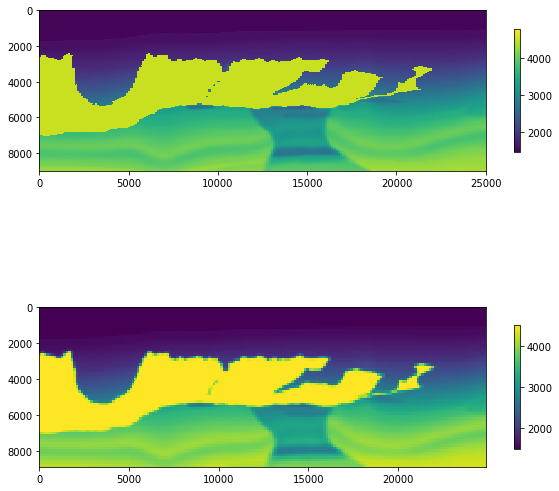

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.pcolormesh(BP_model["x"][::10], BP_model["y"][::10], BP_model["vp"][::10,::10].T)
plt.axis("scaled")
plt.xlim(x_range)
plt.ylim(y_range)
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)

plt.subplot(212)
plt.pcolormesh(model["x"], model["y"], model["vp"].T)
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)
plt.show()

In [11]:
def add_source(nsrc, nx, nt, dt, f0=5, n_pml=0):
    src_list = []
    src_ix = np.round(np.linspace(0+2*n_pml, nx-2*n_pml, nsrc)).astype('int')
    src_iy = np.ones_like(src_ix) * src_rcv_depth
    src_vec = np.zeros(nt)
    vec = 1e7*ricker(f0, dt)
    src_vec[:len(vec)] = vec[:nt]
    for i in range(nsrc):
        tmp = {"ix": src_ix[i], "iy": src_iy[i], "type": 0, "vec": src_vec}
        src_list.append(tmp)
    return src_list

nsrc = 8
source_list = add_source(nsrc, nx, nt, dt, f0, n_pml)

In [12]:
def add_receiver(nrcv, nsrc, nx, n_pml=0, full=False):
    rcv = {}
    if full:
        rcv['ix'] = np.arange(n_pml, nx-n_pml+1).astype('int')
    else:
        rcv['ix'] = np.round(np.linspace(0+n_pml, nx-n_pml, nrcv)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * src_rcv_depth
    rcv['type'] = np.ones_like(rcv['ix'])
    rcv_list = [rcv] * nsrc
    return rcv_list

receiver_list = add_receiver(int(vp0/f0/dx)*3, nsrc, nx, n_pml, full=True)

In [13]:
def get_smooth_model(model, src):
    if mask_extra_detph > 0:
        vp = model['vp'].copy()
        vp[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vp'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
    else:
        vp = model['vp'].copy()
        vp = gaussian_filter(model['vp'], [5,5], mode='reflect')
    
    vp = np.mean(vp, axis=0, keepdims=True).repeat(nx, axis=0)
    new_model = {"vp":vp, "x":x, "y":y, "dx":dx, "dy":dy}

    return new_model

smooth_model = get_smooth_model(model, source_list[0])

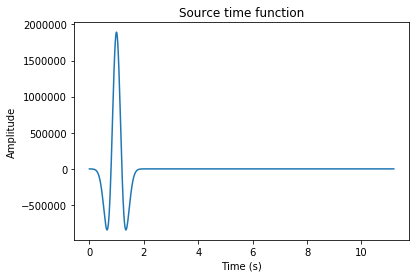

In [14]:
plt.figure()
plt.plot(t, source_list[0]['vec'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Source time function")
plt.show()

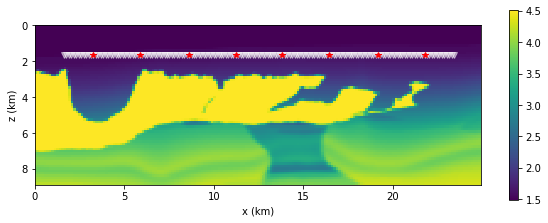

In [15]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "BP-model-vp.png"))
plt.show()

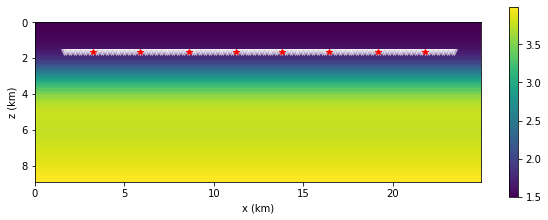

In [16]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vp'].T/1e3)
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "BP-model-smooth-vp.png"))
plt.show()

In [17]:
scipy.io.savemat(os.path.join(out_dir, 'BP-model-true.mat'),
         {"vp" : model['vp'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [18]:
scipy.io.savemat(os.path.join(out_dir, 'BP-model-smooth.mat'),
         {"vp" : smooth_model['vp'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})